In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import scipy.signal as sig

In [18]:
# Read log file
datafile = "logs/" + "20220521T133629.log"
df = pd.read_csv(datafile, header=None)

# Extract wanted columns
# Format according to https://docs.google.com/spreadsheets/d/1eA518KHFowYw7tSMa-NxIFYpiWe5JXgVVQ_IMs7BVW0/edit#gid=0
t = df[1] 
g_lat = df[34]
g_long = df[35]
px = df[4]; py = df[5]; pz = df[6]
pdx = df[8]; pdy = df[9]; pdz = df[10]; 
vrx = df[11]; vry = df[12]; vrz = df[13]; 
vpx = df[14]; vpy = df[15]; vpz = df[16]; 
vel = df[7]

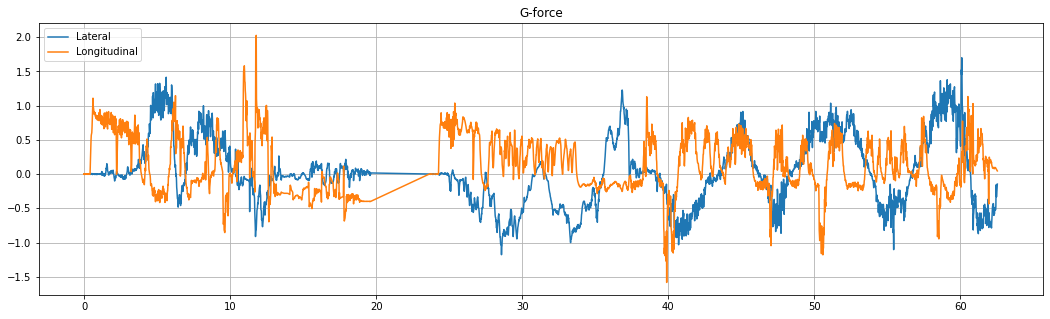

In [19]:
plt.close(1); plt.figure(1, figsize=(18, 5))
plt.plot(t, g_lat, label="Lateral")
plt.plot(t, g_long, label="Longitudinal")
plt.title("G-force")
plt.legend()
plt.grid(True)
#plt.xlim(700, 710)

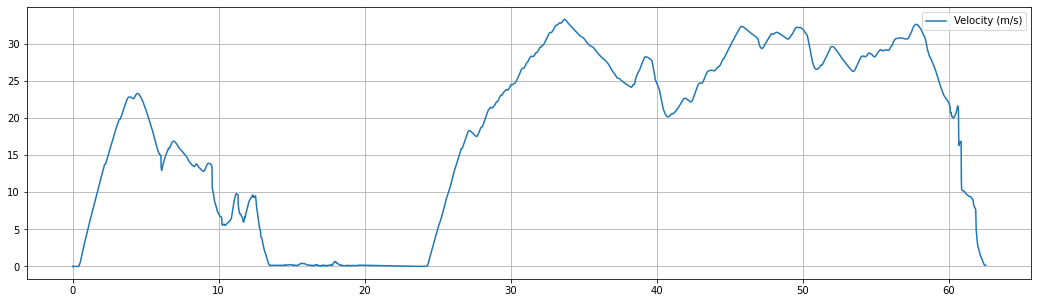

In [20]:
plt.close(2); plt.figure(2, figsize=(18, 5))
plt.plot(t, vel, label="Velocity (m/s)")
plt.grid(True)
plt.legend()

Pitch direction: X:-0.327; Y:-0.024; Z:0.945
Roll direction: X:-0.945; Y:0.004; Z:-0.327


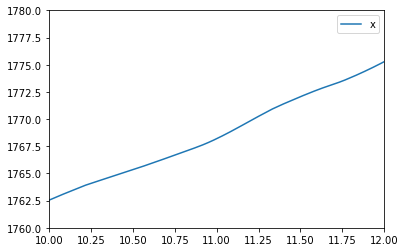

In [21]:
plt.plot(t, px, label="x")
# plt.plot(t, py, label="y")
# plt.plot(t, pz, label="z")
plt.legend()
plt.xlim(10, 12)
plt.ylim(1760, 1780)
print("Pitch direction: X:{:.3f}; Y:{:.3f}; Z:{:.3f}".format(vpx[0], vpy[0], vpz[0]))   # Car X direction - forward
print("Roll direction: X:{:.3f}; Y:{:.3f}; Z:{:.3f}".format(vrx[0], vry[0], vrz[0]))    # Car Z direction - left

In [31]:
# Get acceleration from channels separately
# Convert acceleration vector to car frame (base change matrix)

def Deriv2(t, x, xd_lim, xdd_lim):
    # Calculate first and second derivative of value based on time input
    N = len(t)
    x_prev = 0
    t_prev = 0
    xd = np.zeros(N)
    xdd = np.zeros(N)
    for i in range(N-1):
        dt = t[i+1] - t[i]
        if dt > 0:
            xd[i+1] = (x[i+1] - x[i]) / dt
            xd[i+1] = np.clip(xd[i+1], -xd_lim, xd_lim)
            xdd[i+1] = (xd[i+1] - xd[i]) / dt
            xdd[i+1] = np.clip(xdd[i+1], -xdd_lim, xdd_lim)
        else:
            xd[i+1] = xd[i]
            xdd[i+1] = xdd[i]
    return xd, xdd

def dir_to_euler(dir_x, dir_z):
    roll_xz_norm = np.linalg.norm([dir_z[0], dir_z[2]])
    pitch_xz_norm = np.linalg.norm([dir_x[0], dir_x[2]])

    roll = np.arctan2(dir_z[1], roll_xz_norm)
    pitch = -np.arctan2(dir_x[1], pitch_xz_norm)
    yaw =np.arctan2(dir_x[2], dir_x[0])
    return np.array([roll, pitch, yaw])

def rotate_to_car(a_global, car_x, car_z):
    car_y = np.cross(car_x, car_z)
    a_car = np.array([car_x.T, car_y.T, car_z.T]) @ a_global
    return a_car

In [40]:
L = len(vrx)
rpy = np.zeros((3, L))
for i in range(L):
    vr = np.array([vrx[i], vry[i], vrz[i]])
    vp = np.array([vpx[i], vpy[i], vpz[i]])
    rpy[:, i] = dir_to_euler(vp, vr).T

xd_lim_lin = 350/3.6
xdd_lim_lin = 3*9.81
xd_lim_rot = 3600*np.pi/180
xdd_lim_rot = 720*np.pi/180

_, xdd = Deriv2(t, px, xd_lim_lin, xdd_lim_lin)
_, ydd = Deriv2(t, py, xd_lim_lin, xdd_lim_lin)
_, zdd = Deriv2(t, pz, xd_lim_lin, xdd_lim_lin)
_, r_dd = Deriv2(t, rpy[0,:], xd_lim_rot, xdd_lim_rot)
_, p_dd = Deriv2(t, rpy[1,:], xd_lim_rot, xdd_lim_rot)
_, y_dd = Deriv2(t, rpy[2,:], xd_lim_rot, xdd_lim_rot)

a_lin_local = np.zeros((3, L))
for i in range(L):
    vr = np.array([vrx[i], vry[i], vrz[i]])
    vp = np.array([vpx[i], vpy[i], vpz[i]])
    a_lin_local[:, i] = rotate_to_car(np.array([xdd[i], ydd[i], zdd[i]]).T, vp, vr)
a_rot_local = np.array([r_dd, p_dd, y_dd])

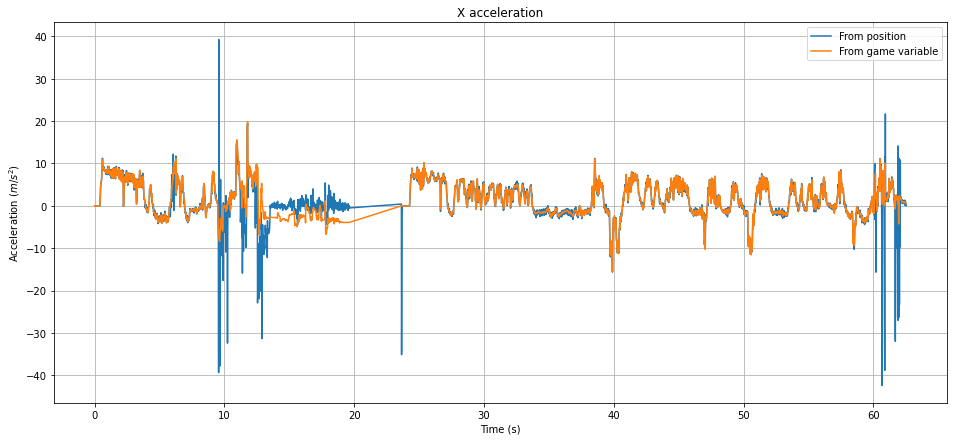

In [43]:
plt.figure(2, figsize=(16,7))
plt.title("X acceleration")
plt.plot(t, a_lin_local[0, :], label="From position")
plt.plot(t, g_long*9.81, label="From game variable")
plt.xlabel("Time (s)")
plt.ylabel(r"Acceleration $(m/s^2)$")
plt.legend()
plt.grid(True)

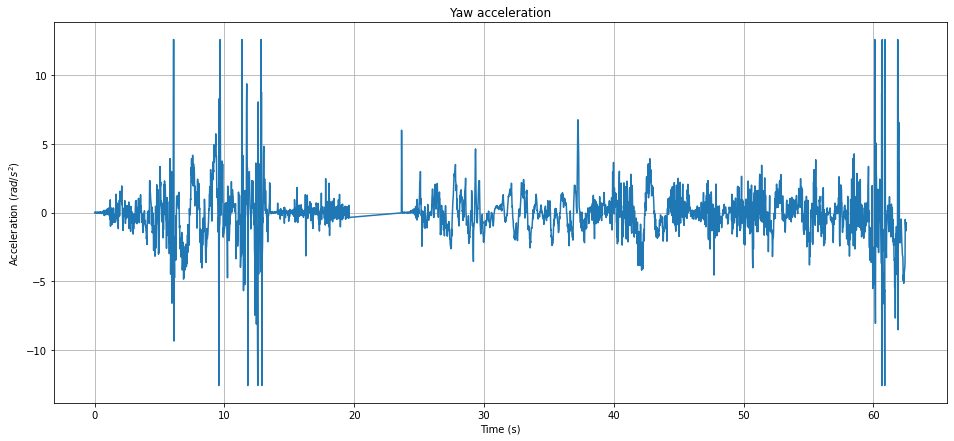

In [45]:
plt.figure(3, figsize=(16,7))
plt.title("Yaw acceleration")
plt.plot(t, a_rot_local[2, :], label="From position")
plt.xlabel("Time (s)")
plt.ylabel(r"Acceleration $(rad/s^2)$")
plt.grid(True)

In [24]:
mdic = {"t":t.array.to_numpy(), "g_lat":g_lat.array.to_numpy(), "g_long":g_long.array.to_numpy(),
        "a_lx":a_lin_local[0,:], "a_ly":a_lin_local[1,:], "a_lz":a_lin_local[2,:],
        "a_rr":a_rot_local[0,:], "a_rp":a_rot_local[1,:], "a_ry":a_lin_local[2,:]}
scipy.io.savemat("logs/gamedata.mat", mdic)